[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qiuyi-Hong/SHEMS/blob/main/analysisSHEMS_v3.ipynb)

In [1]:
# # Install necessary packages: 
# !pip install pyomo pandas openpyxl matplotlib jupyter

# # Install cbc solver: 
# !sudo apt-get install  coinor-cbc coinor-libcbc-dev 

# # Download necessary files:
# import urllib.request, sys

# urls = [
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.py',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.dat',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/Simulation%20Results/simulation_results_concatenated.csv',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/agile-half-hour-actual-rates-25-01-2023_26-01-2024.csv'
#     ]
# file_names = [url.split('/')[-1] for url in urls]

# for i in range(len(urls)):
#     urllib.request.urlretrieve(urls[i], file_names[i])


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
%matplotlib inline
import pyomo.environ as pyo
from SHEMS_v3 import model 

In [3]:
def load_csv(primary_path, secondary_path):
    try:
        data = pd.read_csv(primary_path)
        print("File loaded from primary path.")
    except FileNotFoundError:
        print("Primary path not found. Trying secondary path...")
        data = pd.read_csv(secondary_path)
        print("File loaded from secondary path.")
    return data

# Usage
primary_path = "./Simulation Results/simulation_results_concatenated.csv"
secondary_path = "simulation_results_concatenated.csv"
data = load_csv(primary_path, secondary_path)

File loaded from primary path.


In [4]:
# data = pd.read_csv('./Simulation Results/simulation_results_concatenated.csv')
data.head()

,DateTime,Dry-bulb temperature (°C),Total system energy (kBtu/h),System natural gas (kBtu/h),System electricity (kBtu/h),Total lights energy (kBtu/h),Lights electricity (kBtu/h),Total equip energy (kBtu/h),Equip electricity (kBtu/h),Total CE ex equip (kgCO2/h),...,Total grid disp. elec. PV CE (kgCO2/h),Total CE (kgCO2/h),Electricity (mu),Gas (mu),Renewables (mu),Total nat. gas (kBtu/h),Total electricity (kBtu/h),Total grid displaced elec. PV (kBtu/h),Total energy (kBtu/h),Transformer Losses (kBtu/h)
0,01-01 00:15,5.5,7.460,7.325,0.135,0.0,0.0,2.912,2.912,0.5,...,0.0,0.6,0.06,0.03,0.0,7.325,3.048,0.0,10.372,0.0
1,01-01 00:45,5.5,7.465,7.330,0.135,0.0,0.0,2.912,2.912,0.5,...,0.0,0.6,0.06,0.03,0.0,7.330,3.048,0.0,10.378,0.0
2,01-01 01:15,5.5,7.468,7.333,0.135,0.0,0.0,2.912,2.912,0.5,...,0.0,0.6,0.06,0.03,0.0,7.333,3.048,0.0,10.380,0.0
3,01-01 01:45,5.5,7.467,7.331,0.135,0.0,0.0,2.912,2.912,0.5,...,0.0,0.6,0.06,0.03,0.0,7.331,3.048,0.0,10.379,0.0
4,01-01 02:15,5.5,7.465,7.330,0.135,0.0,0.0,2.912,2.912,0.5,...,0.0,0.6,0.06,0.03,0.0,7.330,3.048,0.0,10.378,0.0


In [5]:
# Solar PV generation
eta = 0.157
S = 20
solar_radiation = data["Direct radiation (W/m²)"]/1000
outdoor_temp = data["Dry-bulb temperature (°C)"]

pv = eta * S * solar_radiation *(1 - 0.005 * (outdoor_temp - 25))

In [6]:
# COP calculation
a = - 0.066
b = 5.7 
COP = a * (outdoor_temp + 30 - outdoor_temp) + b 

In [7]:
T = 48
delta_t = 0.5
demand_ele = data["Total electricity (kBtu/h)"] * 0.29307107
demand_heat = data["Total nat. gas (kBtu/h)"] * 0.29307107

# Electricity price
prices = pd.read_csv('agile-half-hour-actual-rates-25-01-2023_26-01-2024.csv')
ele_import_price = prices["Agile Import price (p/kWh)"]
ele_export_price = prices["Agile Export price (p/kWh)"].astype("float64") 

In [8]:
# Accurate T_inlet calculation when
# T_TES_init = 55 
# Q_TES_init = 12
# m_TES = 300

T_inlet = 55 - (12*3.6e6)/(300*4186)
T_inlet

20.599617773530817

# SHEMS

In [9]:
shems = model.create_instance("SHEMS_v3.dat", namespace="base")

In [10]:
for t in range(1,T+1):
    shems.d_ele._data[t].value = demand_ele[t-1]
    shems.d_heat._data[t].value = demand_heat[t-1]
    shems.p_pv._data[t].value = pv[t-1]
    shems.pi_import._data[t].value = ele_import_price[t-1]
    shems.pi_export._data[t].value = ele_export_price[t-1]
    shems.T_out._data[t].value = outdoor_temp[t-1]
    shems.COP._data[t].value = COP[t-1]
    shems.T_inlet.value = T_inlet

In [11]:
from sys import platform

if platform == "linux":
    # linux
    solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
elif platform == "darwin":
    # OS X
    solver = pyo.SolverFactory('cbc')

solver.solve(shems)

{'Problem': [{'Name': 'unknown', 'Lower bound': 1410.81860916, 'Upper bound': 1410.81860916, 'Number of objectives': 1, 'Number of constraints': 286, 'Number of variables': 284, 'Number of binary variables': 96, 'Number of integer variables': 96, 'Number of nonzeros': 96, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.12, 'Wallclock time': 0.13, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 2, 'Number of created subproblems': 2}, 'Black box': {'Number of iterations': 707}}, 'Error rc': 0, 'Time': 0.17181396484375}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Visualisation

In [12]:
# Values of decision variables
values = pd.DataFrame(data={'T_TES': [shems.T_TES._data[t].value for t in range(1,T+1)],
                            'q_HP': [shems.q_HP._data[t].value for t in range(1,T+1)],                           
                            'p_HP': [shems.p_HP._data[t].value for t in range(1,T+1)],
                            'q_SH': [shems.q_SH._data[t].value for t in range(1,T+1)],
                            'q_DHW': [shems.q_DHW._data[t].value for t in range(1,T+1)],
                            'T_in': [shems.T_in._data[t].value for t in range(1,T+1)],
                            'epsilon_SH': [shems.epsilon_SH._data[t].value for t in range(1,T+1)],
                            'epsilon_TES': [shems.epsilon_TES._data[t].value for t in range(1,T+1)],
                            'Q_TES': [shems.Q_TES._data[t].value for t in range(1,T+1)],
                            'q_TES_d': [shems.q_TES_d._data[t].value for t in range(1,T+1)],
                            'p_import': [shems.p_import._data[t].value for t in range(1,T+1)],
                            'p_export': [shems.p_export._data[t].value for t in range(1,T+1)]})
                      

In [13]:
values.head()

,T_TES,q_HP,p_HP,q_SH,q_DHW,T_in,epsilon_SH,epsilon_TES,Q_TES,q_TES_d,p_import,p_export
0,59.481898,8.500000,2.284946,0.0,8.500000,19.894938,0.230319,1.079638,13.563435,4.293491,2.035754,0.0
1,51.990872,0.000000,0.000000,0.0,0.000000,19.790637,0.228650,0.929817,10.950316,4.296422,0.893281,0.0
2,50.000000,3.799215,1.021294,0.0,3.799215,19.687093,0.226993,0.890000,10.255833,4.298180,1.403928,0.0
3,50.000000,5.187008,1.394357,0.0,5.187008,19.584298,0.225349,0.890000,10.255833,4.297008,1.590459,0.0
4,50.000000,5.186422,1.394199,0.0,5.186422,19.482248,0.223716,0.890000,10.255833,4.296422,1.590380,0.0


In [14]:
T_TES = [shems.T_TES._data[t].value for t in range(1,T+1)]
q_HP = [shems.q_HP._data[t].value for t in range(1,T+1)]
p_HP = [shems.p_HP._data[t].value for t in range(1,T+1)]
q_SH = [shems.q_SH._data[t].value for t in range(1,T+1)]
q_DHW = [shems.q_DHW._data[t].value for t in range(1,T+1)]
T_in = [shems.T_in._data[t].value for t in range(1,T+1)]
epsilon_SH = [shems.epsilon_SH._data[t].value for t in range(1,T+1)]
epsilon_TES = [shems.epsilon_TES._data[t].value for t in range(1,T+1)]
Q_TES = [shems.Q_TES._data[t].value for t in range(1,T+1)]
q_TES_d = [shems.q_TES_d._data[t].value for t in range(1,T+1)]
p_import = [shems.p_import._data[t].value for t in range(1,T+1)]
p_export = [shems.p_export._data[t].value for t in range(1,T+1)]

d_ele = [shems.d_ele._data[t].value for t in range(1,T+1)]
d_heat = [shems.d_heat._data[t].value for t in range(1,T+1)]
p_pv = [shems.p_pv._data[t].value for t in range(1,T+1)]

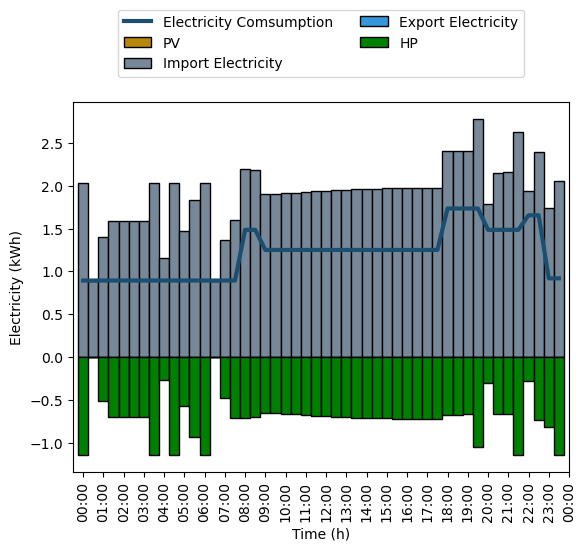

In [15]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_ele), label="Electricity Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(p_pv)*delta_t, width=bar_width, label="PV", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(p_import), bottom=np.array(p_pv)*delta_t, width=bar_width, label="Import Electricity", color="#778899", edgecolor="black")

ax1.bar(time_range, np.negative(p_export), width=bar_width, label="Export Electricity", color="#3498DB", edgecolor="black")

ax1.bar(time_range, np.negative(p_HP)*delta_t, bottom=np.negative(p_export), width=bar_width, label="HP", color="#008000", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity (kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig("shems_electricity.pdf", bbox_inches='tight')
plt.show()

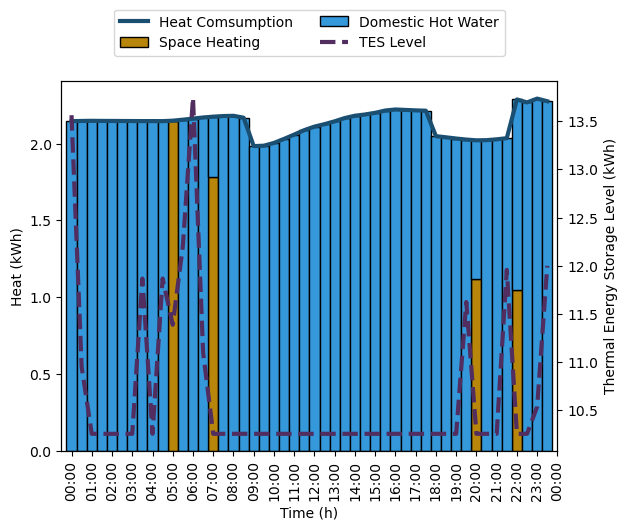

In [16]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_heat), label="Heat Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_SH)*delta_t, width=bar_width, label="Space Heating", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(q_TES_d)*delta_t, bottom= np.array(q_SH)*delta_t, width=bar_width, label="Domestic Hot Water", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(Q_TES), label="TES Level", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("Thermal Energy Storage Level (kWh)")
# ax2.legend()

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig("shems_heat.pdf", bbox_inches='tight')
plt.show()

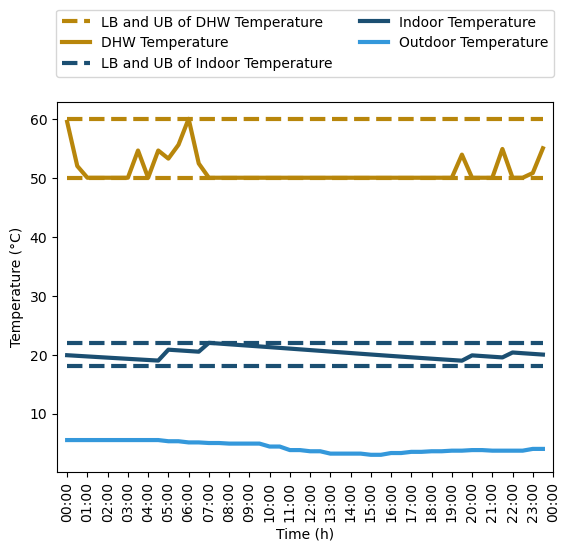

In [17]:
T_TES_LB = shems.T_TES_LB.value
T_TES_UB = shems.T_TES_UB.value

T_in_LB = shems.T_in_LB.value
T_in_UB = shems.T_in_UB.value

T_out = [shems.T_out._data[t].value for t in range(1,T+1)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array([T_TES_UB]*T), label="LB and UB of DHW Temperature", color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_TES), label="DHW Temperature", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_TES_LB]*T), color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array([T_in_UB]*T), label="LB and UB of Indoor Temperature", color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_in), label="Indoor Temperature", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_in_LB]*T), color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_out), label="Outdoor Temperature", color="#3498DB", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Temperature (°C)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig("shems_temperature.pdf", bbox_inches='tight')
plt.show()

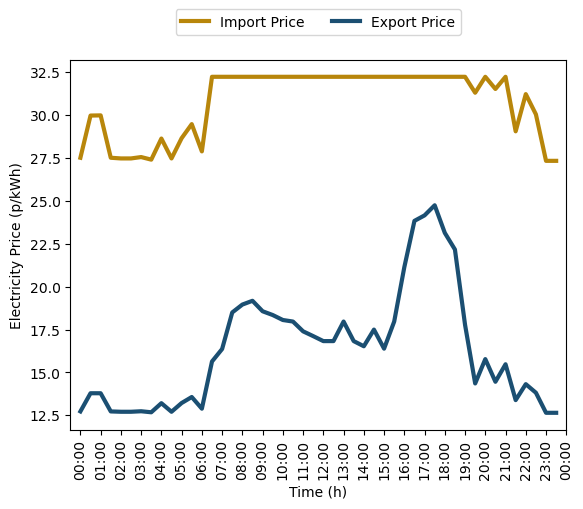

In [18]:
pi_import = [shems.pi_import._data[t].value for t in range(1,T+1)]
pi_export = [shems.pi_export._data[t].value for t in range(1,T+1)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(pi_import), label="Import Price", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array(pi_export), label="Export Price", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity Price (p/kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig("electricity_prices.pdf", bbox_inches='tight')
plt.show()